# Защита персональных данных клиентов

Требуется защитить данные клиентов страховой компании «Хоть потоп». Мы предложим метод преобразования данных, после применения которого сложно восстановить персональную информацию и обоснуем корректность его работы,т.е. что при использовании данного метода качество моделей машинного обучения не ухудшится. 

## Загрузка данных

Мы видим, что данные представлены четырьмя колонками признаков (пол, возраст, величина зарплаты, количество членов семьи), целевым же признаком является количество полученных страховых выплат.
Данные не содержат пропусков, но содержат дубликаты. Дубликаты оставлены, поскольку могло иметь место просто совпадение чисел (нет уникального идентификатора клиента). Изучение распределения признаков показывает, что признаки не содержат нереалистичных данных, а значит не требуют предобработки.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [48]:
data = pd.read_csv('/datasets/insurance.csv')
display(data.head())
data.info()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [49]:
data.duplicated().sum()

153

In [51]:
data_age_salary = pd.concat([data['Возраст'].describe(), data['Зарплата'].describe()], axis=1)
display(data_age_salary)
                             

,Возраст,Зарплата
count,4847.000000,4847.000000
mean,31.023932,39895.811842
std,8.487995,9972.953985
min,18.000000,5300.000000
25%,24.000000,33200.000000
50%,30.000000,40200.000000
75%,37.000000,46600.000000
max,65.000000,79000.000000


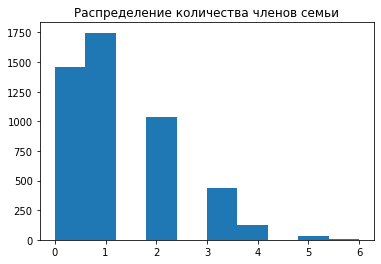

In [52]:
plt.hist(data['Члены семьи'])
plt.title('Распределение количества членов семьи')
plt.show();



In [53]:
display(data.groupby('Пол')['Пол'].count())

Пол
0    2431
1    2416
Name: Пол, dtype: int64

In [54]:
display(data.groupby('Страховые выплаты')['Страховые выплаты'].count())

Страховые выплаты
0    4284
1     423
2     114
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

## Умножение матриц

Предположим, что признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии, если её можно обучить заново?

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

\begin{equation}
w = \arg\min_w MSE(Xw, y)
\end{equation}

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** При умножении на обратимую матрицу качество регрессии не изменится.

**Обоснование:** Пусть мы разбили признаки и целевой признак на обучающую и тестовую части, т.е $X_{train}, y_{train}, X_{test}, y_{test}$ --- матрица признаков и вектор целевого признака для обучающей и тестовой выборок, соответственно. 

Тогда матрица $w$ находится по формуле
$$
w = (X_{train}^T X_{train})^{-1} ~X_{train}^T ~y_{train},
$$
а качество обучения на тестовой выборке определяется метрикой
$$
\mu(y_{pred}, y_{test}), ~~ y_{pred} = X_{test} w,
$$
где $\mu$ - выбранная метрика (*MSE, r2_score*, и т.д.)

Предположим, мы умножаем матрицы признаков с добавленным первым столбцом единиц на обратимую матрицу A размера $(n+1) \cdot (n+1)$, т.е.
\begin{equation}
X'_{train} = X_{train} A, ~~ y'_{train} = A, ~~ X'_{test} = X_{test} A, ~~
\end{equation}
тогда новая матрица $w'$ имеет вид
$$
w' = ((X_{train} A)^T X_{train} A)^{-1} (X_{train} A)^T y_{train} = (A^T X_{train}^T X_{train} A)^{-1} A^T X^T_{train} y_{train}
$$
$$
= A^{-1} (X_{train}^T X_{train})^{-1} (A^T)^{-1} A^T X^T_{train} y_{train} = A^{-1}~ (X_{train}^T X_{train})^{-1} ~X^T_{train}~ y_{train} = A^{-1}w.
$$
Новые предсказания не тестовой выборке не изменятся, поскольку
$$
y'_{pred} =  X'_{test} w' = X_{test} A A^{-1}w = X_{test} w = y_{pred},
$$
а значит любая метрика качества обучения сохранит своё значение.

Замечание: в наших выкладках мы использовали следующие свойства матриц: $(AB)^T = B^T A^T$, $(AB)^{-1} = B^{-1} A^{-1}$ и $A^{-1}A = AA^{-1} = E$.

## Алгоритм преобразования

**Алгоритм**
- к матрице признаков добавим слева столбец единиц, назовём полученную матрицу расширенной матрицей признаков;

- умножим расширенную матрицу признаков справа  на  сгенерированную обратимую матрицу, размера $(n+1)*(n+1)$, где $n$ - количество признаков, получим зашифрованную матрицу признаков;

- обучим модель на зашифрованных данных и получим предсказания

**Обоснование**
В разделе "Умножение матриц" доказано, что при таком преобразовании предсказания не изменятся, а значит качество машинного обучения также сохранится.

## Проверка алгоритма
Созданим класс линейной регрессии, согласно предложенной формуле обучения.

In [55]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = train_features 
        y = train_target
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        

    def predict(self, test_features):
        return test_features.dot(self.w)

Сначала обучим модель на исходных (незашифрованных) данных. Разобьём данные на тренировочную и тестовую выборки, проверив корректность разбиения.

In [56]:
features = data.drop(['Страховые выплаты'], axis = 1).astype('float')
target = data['Страховые выплаты']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)


(3635, 4) (1212, 4) (3635,) (1212,)


Добавим столбец единиц справа к  тестовой и тренировочной части данных, поскольку формула обучения предполагает использование расширенной матрицы признаков. Обучим модель на незашифрованных данных, вычислим метрику `r2-score` и дополнительно выведем вектор предказаний для тестовой части выборки.

In [57]:
features_train_enlarged = np.concatenate((np.ones((features_train.shape[0], 1)), features_train), axis=1)
features_test_enlarged = np.concatenate((np.ones((features_test.shape[0], 1)), features_test), axis=1)

model = LinearRegression()
model.fit(features_train_enlarged, target_train)
predictions_test = model.predict(features_test_enlarged)
print('r2_score на незашифрованных данных ', r2_score(target_test, predictions_test))

print('Вектор предказаний:')
print(predictions_test)

r2_score на незашифрованных данных  0.4230772749214827
Вектор предказаний:
[-0.11466092  0.21699995  0.22306595 ... -0.04468839 -0.05881157
  0.89181229]


Сгенерируем произвольную матрицу A подходящего размера, проверив её обратимость.

In [58]:
n = features.shape[1]
A = np.random.rand(n+1, n+1)
print(A)
try:
    A1 = np.linalg.inv(A)
    print(A1)
except:
    print('Матрица А вырождена')

[[0.12354817 0.87551871 0.44409176 0.57338499 0.00207594]
 [0.83190071 0.69398881 0.63333857 0.9159159  0.37501831]
 [0.45172047 0.86944289 0.66935953 0.96787398 0.36826718]
 [0.8099552  0.82004067 0.55751782 0.33446648 0.76650633]
 [0.38183627 0.40367421 0.22386034 0.19974117 0.28477762]]
[[  0.43076983   2.19901919  -2.52580304  -0.54232744   1.82704338]
 [  0.75993069  -1.49609287   0.22505205  -1.88255501   6.7406831 ]
 [  3.54478538   4.0093775   -4.02641879   8.80096058 -23.78748299]
 [ -2.24423765  -1.28354726   3.30492393  -3.82198816   7.7200438 ]
 [ -2.86721326  -3.07922561   3.9147093   -0.84191458   4.79107887]]


Зашифруем данные, умножим расширенную матрицу признаков справа на матрицу A.

In [59]:
features_train_encrypted = np.concatenate((np.ones((features_train.shape[0], 1)), features_train), axis=1) @ A
features_test_encrypted = np.concatenate((np.ones((features_test.shape[0], 1)), features_test), axis=1) @ A


Обучим модель на зашифрованных данных, выведем метрику `r2_score` и вектор предсказаний.

In [60]:
model = LinearRegression()
model.fit(features_train_encrypted, target_train)
predictions_test = model.predict(features_test_encrypted)
print('r2_score на зашифрованных данных ', r2_score(target_test, predictions_test))
print('Вектор предказаний:')
print(predictions_test)

r2_score на зашифрованных данных  0.4230835403776698
Вектор предказаний:
[-0.11458988  0.21698315  0.22308307 ... -0.04467313 -0.05872208
  0.89179577]


## Вывод
Предложенным нами алгоритм шифрования персональных данных, состоящий в умножении матрицы признаков на случайную обратимую матрицу, работает корректно, и сохраняет качество линейной регрессии. Более того, предложенный алгоритм сохраняет вектор предсказаний.